In [1]:
from pyteomics import mgf
import pandas as pd
import numpy as np
import glob as glob
import os
import sys
import matplotlib.pyplot as plt
import networkx as nx
import pingouin as pg
import seaborn as sns
sys.path.insert(0,'/global/homes/b/bpb/repos/metatlas')
from metatlas.io import feature_tools as ft

import pandas as pd
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
import networkx as nx
import os
import glob

from typing import List, Tuple

from tqdm.notebook import tqdm

# replace with submodules



# sys.path.insert(0,'../')
import analysis_tools as at

INFO:rdkit:Enabling RDKit 2023.09.1 jupyter extensions


In [33]:
# experiment directory
## note: must follow JGI file naming conventions and be converted to hdf5 format


# Syndac5 experiment
# /global/cfs/cdirs/metatlas/raw_data/egsb/20230706_EB_CL_107002-011_SynDAC5_20230630_EXP120A_C18-EP_USDAY72349


# wavestab1 experiment
exp_dir = '/global/cfs/cdirs/metatlas/raw_data/egsb/20231018_EB_MdR_109570-002_WAVEstab_20231017_EXP120A_C18-EP_USDAY72349_vols'
group_control = 'supern-WAVE-NatCom-NLDM-Day0'
group_treatment = 'supern-WAVE-NatCom-NLDM-Day7'
my_groups = {'control':group_control,'treatment':group_treatment}
experiment_name = 'wavestab1'
output_filename = f'OUTPUT_{experiment_name}_{group_treatment}-vs-{group_control}.csv'
# print(output_filename)
####  All groups for wavestab1
# ['supern-WAVE-NatCom-NLDM-Day7', 'TxCtrl-NA-Sterile-Salts-Day0',
#        'TxCtrl-NA-Sterile-NLDM-Day0', 'supern-WAVE-NatCom-Salts-Day0',
#        'supern-WAVE-NatCom-Salts-Day7', 'supern-WAVE-NatCom-NLDM-Day0']


# russell ranch experiment
# exp_dir = '/global/cfs/cdirs/metatlas/raw_data/egsb/20231113_EB_SMK_107002-011_CenturyExp_20230414_EXP120A_C18-EP_USDAY72349'
# group_control = 'supern-CentExp-OMT1d2-NatCom-d0-NA'
# group_treatment = 'supern-CentExp-OMT1d2-NatCom-d7-NA'
# my_groups = {'control':group_control,'treatment':group_treatment}
# experiment_name = 'wavestab3'
# output_filename = f'OUTPUT_{experiment_name}_{group_treatment}-vs-{group_control}.csv'

# # wavestab3 experiment
# exp_dir  = '/global/cfs/cdirs/metatlas/raw_data/egsb/20240125_EB_MdR_101544-059_WAVESTAB3_20231222_EXP120A_C18-EP_USDAY72349'
# group_control = 'supern-CentExp-OMT1d2-NatCom-d0-NA'
# group_treatment = 'supern-CentExp-OMT1d2-NatCom-d7-NA'
# my_groups = {'control':group_control,'treatment':group_treatment}
# experiment_name = 'wavestab3'
# output_filename = f'OUTPUT_{experiment_name}_{group_treatment}-vs-{group_control}.csv'

# exp_dir  = '/global/cfs/cdirs/metatlas/raw_data/egsb/20230530_EB_MdR_101544-059_SynDAC3_20230512_QE144_C18-EP_USDAY72350'
# group_control = 'TxCtrl-NA-NA-CA'
# group_treatment = 'RXN-Lac-CA-CA'
# my_groups = {'control':group_control,'treatment':group_treatment}
# experiment_name = 'SynDAC5'
# output_filename = f'OUTPUT_{experiment_name}_{group_treatment}-vs-{group_control}.csv'

# tolerance in ppm between experimental signal and node mz
mz_ppm_tolerance = 5
peak_height_min = 1e4
num_datapoints_min = 10
# minimum MSMS score 
msms_score_min = 0.5

# minimum MSMS matching ion count
msms_matches_min = 3

# retention time range in minutes for feature finding
rt_range = [1, 700]

# tolerance in daltons used for calculating MS/MS similarity scores
frag_mz_tolerance = 0.05

# combine all parameters into a single dictionary and export to a file
params = {'mz_ppm_tolerance':mz_ppm_tolerance,
          'peak_height_min':peak_height_min,
          'num_datapoints_min':num_datapoints_min,
          'msms_score_min':msms_score_min,
          'msms_matches_min':msms_matches_min,
          'rt_range':rt_range,
          'frag_mz_tolerance':frag_mz_tolerance}
params['exp_dir'] = exp_dir
params['my_groups'] = my_groups
params['output_filename'] = output_filename

with open(output_filename.replace('.csv','.params'),'w') as f:
    for key in params.keys():
        f.write("%s: %s\n"%(key,params[key]))

In [34]:
# collect and merge required data and metadata

node_data = at.graph_to_df()
node_atlas = at.make_node_atlas(node_data, rt_range)
merged_node_data = at.merge_spectral_data(node_data)
files_data = at.get_files_df(exp_dir,parse_filename=True,groups=my_groups)
files = files_data['filename'].tolist()

cols = ['inchi_key_identity','smiles_identity']
data = node_data[cols].copy()
data.drop_duplicates('inchi_key_identity',inplace=True)
data = data[pd.notna(data['inchi_key_identity'])]
data.rename(columns={'inchi_key_identity':'inchi_key','smiles_identity':'smiles'},inplace=True)
data.head()
# sys.path.insert(0,'.')
from get_compound_descriptors import calc_descriptor_df
# from importlib import reload
# gcd = reload(gcd)
data = calc_descriptor_df(data)

INFO:root:Processing original_spectra.mgf
INFO:root:Processing nl_spectra.mgf


In [35]:
data

,inchikey,mol,property: exactmw,property: amw,property: lipinskiHBA,property: lipinskiHBD,property: NumRotatableBonds,property: NumHBD,property: NumHBA,property: NumHeavyAtoms,...,descriptor: fr_sulfide,descriptor: fr_sulfonamd,descriptor: fr_sulfone,descriptor: fr_term_acetylene,descriptor: fr_tetrazole,descriptor: fr_thiazole,descriptor: fr_thiocyan,descriptor: fr_thiophene,descriptor: fr_unbrch_alkane,descriptor: fr_urea
0,SWEPQJJUAVEABL-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7fc3ef463350>,231.147058,231.292,5.0,3.0,6.0,3.0,3.0,16.0,...,0,0,0,0,0,0,0,0,0,0
1,SAVLIIGUQOSOEP-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7fc6dabf4900>,201.136493,201.266,4.0,2.0,8.0,2.0,2.0,14.0,...,0,0,0,0,0,0,0,0,3,0
2,RFMMMVDNIPUKGG-YFKPBYRVSA-N,<rdkit.Chem.rdchem.Mol object at 0x7fc6dabf47b0>,189.063722,189.167,6.0,3.0,5.0,3.0,3.0,13.0,...,0,0,0,0,0,0,0,0,0,0
3,RFMMMVDNIPUKGG-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7fc6dabf4ac0>,189.063722,189.167,6.0,3.0,5.0,3.0,3.0,13.0,...,0,0,0,0,0,0,0,0,0,0
4,KKEYFWRCBNTPAC-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7fc6dabf4c10>,166.026609,166.132,4.0,2.0,2.0,2.0,2.0,12.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,YPIDZFLQKNEKRA-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7fc3fa459740>,154.062994,154.165,3.0,2.0,1.0,2.0,3.0,11.0,...,0,0,0,0,0,0,0,0,0,0
1120,ISFMXVMWEWLJGJ-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7fc3fa459820>,234.161980,234.339,2.0,1.0,0.0,1.0,2.0,17.0,...,0,0,0,0,0,0,0,0,0,0
1121,QFOHBWFCKVYLES-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7fc3fa459ba0>,194.094294,194.230,3.0,1.0,4.0,1.0,3.0,14.0,...,0,0,0,0,0,0,0,0,1,0
1122,VBBXZFLAYWAXSK-HYJCDKNOSA-N,<rdkit.Chem.rdchem.Mol object at 0x7fc3fa4599e0>,292.167459,292.375,4.0,1.0,3.0,1.0,3.0,21.0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# get ms1 and ms2 data
ms1_data = at.get_sample_ms1_data(node_atlas, files, mz_ppm_tolerance,peak_height_min,num_datapoints_min)
max_ms1_data = at.get_best_ms1_rawdata(ms1_data,node_data)
ms2_data = at.get_sample_ms2_data(files,merged_node_data,msms_score_min,msms_matches_min,mz_ppm_tolerance,frag_mz_tolerance)
max_ms2_data = at.get_best_ms2_rawdata(ms2_data)
best_hits = at.get_best_ms1_ms2_combined(max_ms1_data,max_ms2_data)

stats_df = at.do_basic_stats(ms1_data,files_data)
output_df = at.make_output_df(node_data,best_hits,stats_df,filename=output_filename)


  0%|          | 0/16 [00:00<?, ?file/s]

  0%|          | 0/16 [00:00<?, ?file/s]

In [37]:
cols = ['inchi_key_identity','log2_foldchange','p_value']
d = output_df[cols]
d = d[pd.notna(d['inchi_key_identity'])]
d = d[pd.notna(d['log2_foldchange'])]
d = d[d['p_value'] < 0.05]
d = pd.merge(d,data,left_on='inchi_key_identity',right_on='inchikey',how='inner')
cols = [c for c in d.columns if c.startswith('property')]
for c in cols:
    d[c] = d[c].astype(float)
    x = d['log2_foldchange']
    y = d[c]
    idx = pd.notna(x) & pd.notna(y)
    corr = pg.corr(x[idx],y[idx])
    r = corr["r"].values[0]
    p = corr["p-val"].values[0]
    if abs(r) > 0.04 and p < 0.05:
        print(f'{c}: r={corr["r"].values[0]:.2f}, p={corr["p-val"].values[0]:.2e}')
    
    # print(f'{c}: r={r:.2f}, p={p:.2e}')


property: lipinskiHBA: r=-0.29, p=3.76e-11
property: lipinskiHBD: r=-0.16, p=2.43e-04
property: NumRotatableBonds: r=0.30, p=2.37e-11
property: NumHBD: r=-0.15, p=9.26e-04
property: NumHBA: r=-0.30, p=2.32e-11
property: NumHeavyAtoms: r=-0.09, p=3.61e-02
property: NumAtoms: r=0.11, p=1.31e-02
property: NumHeteroatoms: r=-0.29, p=3.39e-11
property: FractionCSP3: r=0.20, p=6.68e-06
property: NumRings: r=-0.26, p=5.09e-09
property: NumAromaticRings: r=-0.24, p=7.53e-08
property: NumHeterocycles: r=-0.18, p=9.20e-05
property: NumAromaticHeterocycles: r=-0.12, p=8.90e-03
property: NumAliphaticHeterocycles: r=-0.12, p=1.06e-02
property: tpsa: r=-0.27, p=9.92e-10
property: CrippenClogP: r=0.22, p=5.03e-07
property: hallKierAlpha: r=0.36, p=1.25e-16
property: kappa2: r=0.27, p=9.54e-10
property: kappa3: r=0.32, p=4.06e-13
property: Phi: r=0.31, p=4.08e-12


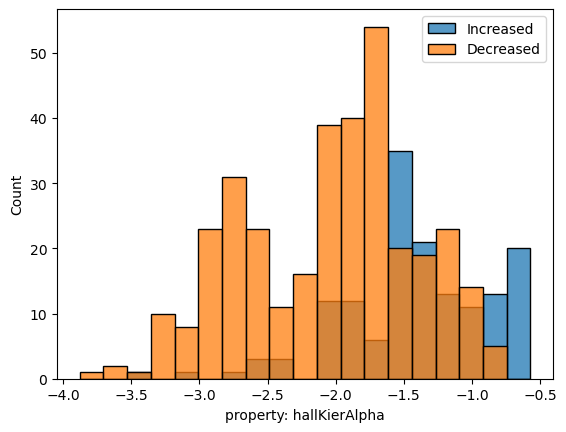

In [40]:
my_prop = 'property: hallKierAlpha'
x = d['log2_foldchange']
y = d[my_prop]
idx = pd.notna(x) & pd.notna(y)
x = x[idx]
y = y[idx]
idx = x > 0 # not eaten?    
fig,ax = plt.subplots()
bins = np.linspace(y.min(),y.max(),20)
sns.histplot(y[idx],ax=ax,bins=bins,label='Increased')
idx = x < 0 #eaten?
sns.histplot(y[idx],ax=ax,bins=bins,label='Decreased')
plt.legend()


In [34]:
df1 = pd.read_csv('OUTPUT_wavestab1_supern-WAVE-NatCom-NLDM-Day7-vs-supern-WAVE-NatCom-NLDM-Day0.csv')
df2 = pd.read_csv('OUTPUT_wavestab3_supern-CentExp-OMT1d2-NatCom-d7-NA-vs-supern-CentExp-OMT1d2-Sterile-d0-NA.csv')
df1 = df1[df1['p_value']>0.05]
df2 = df2[df2['p_value']>0.05]
df1 = df1[abs(df1['log2_foldchange'])<0.25]
df2 = df2[abs(df2['log2_foldchange'])<0.25]
df1 = df1[df1['ms2_matches']>0]
df2 = df2[df2['ms2_matches']>0]
nodes = list(set(df1['node_id'].tolist()) & set(df2['node_id'].tolist()))
smiles = df1.loc[df1['node_id'].isin(nodes),'smiles_identity'].unique()
from rdkit import Chem
from rdkit.Chem import Draw

mols = [Chem.MolFromSmiles(s) for s in smiles]
Draw.MolsToGridImage(mols, molsPerRow=4)

((40, 71), (76, 71))

In [35]:
df1.columns

Index(['node_id', 'original_index', 'massive_id', 'no_extension_basename',
       'title', 'description', 'precursor_mz', 'isolated_precursor_mz', 'rt',
       'coisolated_precursor_count', 'predicted_formula', 'estimated_fdr',
       'predicted_mass', 'mass_error', 'num_mdm_frags', 'max_score_identity',
       'best_match_method_identity', 'max_matches_identity', 'name_identity',
       'inchi_key_identity', 'smiles_identity', 'formula_identity',
       'precursor_mz_identity', 'original_p2d2_index_identity',
       'isin_fticr_formula', 'dbe', 'dbe_ai', 'dbe_ai_mod', 'ai_mod', 'ai',
       'nosc', 'h_to_c', 'o_to_c', 'n_to_c', 'p_to_c', 'c', 'h', 'o', 'n', 's',
       'p', 'class_results', 'superclass_results', 'pathway_results',
       'class_results_propagated', 'superclass_results_propagated',
       'pathway_results_propagated', 'n_to_p', 'num_datapoints', 'peak_area',
       'peak_height', 'mz_centroid', 'rt_peak', 'lcmsrun_observed',
       'precursor_mz_best_hit', 'ppm_error',

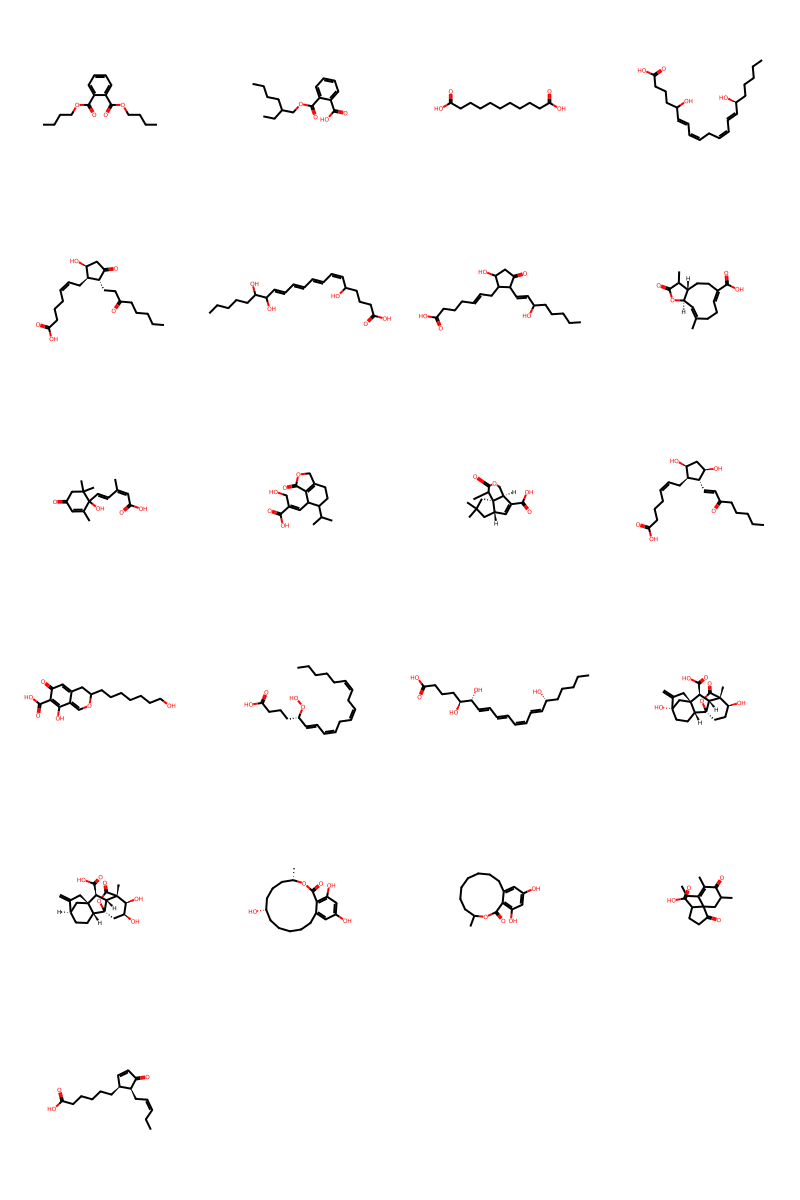